### The key imports:

In [1]:
%load_ext autoreload
%autoreload 2
from xrayproject.utils import load_pngs, get_img_sizes, get_img_heights, get_img_widths
from xrayproject import utils
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
from PIL import Image
import pandas as pd
import numpy as np

# Loading and playing with the data:

### Importing the data and looking at the X-ray scans. Also, some silly code to extract the sizes of the images.

*Here, we simply load and look at the data.* The point here is to test if things compile/run at friggin all. Seems the PRC is in black-and-white, while the USA is in color. I'm sure there's some pithy analogy, there. But I just want a baseline model for now...

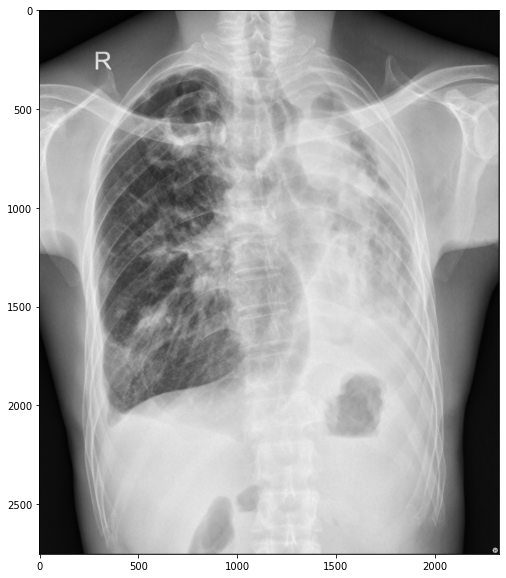

[(0, 2620, 2435), (1, 2752, 2328), (2, 2917, 2580), (3, 2933, 2734), (4, 2951, 2824), (5, 2955, 3000), (6, 2943, 2997), (7, 2452, 2384), (8, 2933, 2997), (9, 2947, 3000)]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


In [2]:
path = '../raw_data/raw_PRC/CXR_png'
img_PRC, target_PRC, ID = load_pngs(10, get_all=False, get_target=True, get_random=True, balanced=True, path=path)
plt.subplots(figsize = (10,10))
plt.imshow(img_PRC[1])
plt.show()
print([(i, img_PRC[i].shape[0], img_PRC[i].shape[1]) for i in range(10) ])
print(target_PRC)

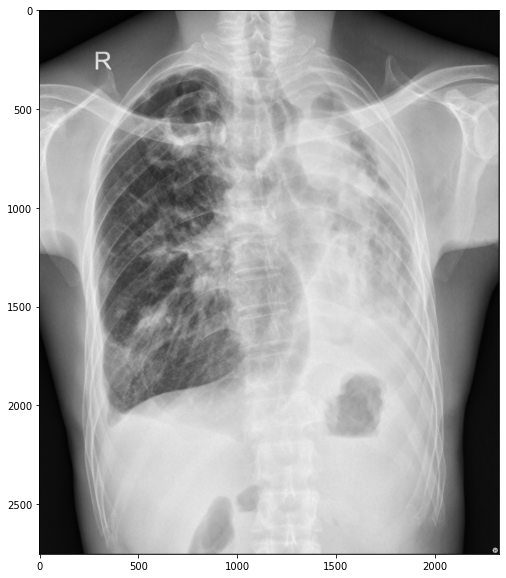

[(0, 2889, 2776), (1, 2672, 2546), (2, 2795, 2598), (3, 2660, 2416), (4, 2640, 2503), (5, 2921, 3000), (6, 2935, 3000), (7, 989, 1255), (8, 2537, 2501), (9, 2927, 2699)]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


In [3]:
path = '../raw_data/raw_PRC/CXR_png'
img_USA, target_USA, ID = load_pngs(10, get_all=False, get_target=True, get_random=True, balanced=True, path=path)
plt.subplots(figsize = (10,10))
plt.imshow(img_PRC[1])
plt.show()
print([(i, img_USA[i].shape[0], img_USA[i].shape[1]) for i in range(10) ])
print(target_USA)

In [4]:
print(img_USA[0].shape, img_USA[1].shape)
print(img_USA[5].shape, img_USA[6].shape)
# plt.imshow(img_USA[5])
# plt.imshow(img_USA[6])
# plt.show()

(2889, 2776, 3) (2672, 2546, 3)
(2921, 3000, 3) (2935, 3000, 3)


(2672, 2546, 3)


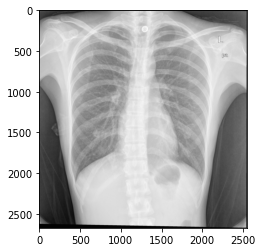

In [5]:
print(img_USA[1].shape)
plt.imshow(img_USA[1])
plt.show()

In [6]:
print(target_USA)
print(target_PRC)

[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


Now that we have the data, let's look at the dimensions of the files.

In [7]:
def dim_imgs(examples):
    return [(example.shape[0], example.shape[1]) for example in examples]

In [8]:
print(dim_imgs(img_PRC))
print(dim_imgs(img_USA))

[(2620, 2435), (2752, 2328), (2917, 2580), (2933, 2734), (2951, 2824), (2955, 3000), (2943, 2997), (2452, 2384), (2933, 2997), (2947, 3000)]
[(2889, 2776), (2672, 2546), (2795, 2598), (2660, 2416), (2640, 2503), (2921, 3000), (2935, 3000), (989, 1255), (2537, 2501), (2927, 2699)]


In [9]:
def max_min_sizes(path,max_size_guess=10,min_size_guess=10000):
    biggest_size = max_size_guess
    smallest_size = min_size_guess
    for size in get_img_sizes(path):
        big_size = max(size[0], size[1])
        small_size = min(size[0], size[1])
        if big_size > biggest_size:
            biggest_size = big_size
        if small_size < smallest_size:
            smallest_size = small_size
    return (biggest_size, smallest_size)

def distinct_sizes(path):
    other_sizes = []
    biggest_size = max_min_sizes(path)[0]
    smallest_size = max_min_sizes(path)[1]
    for size in get_img_sizes(path):
        if smallest_size != min(size[0], size[1]):
            other_sizes.append(min(size[0],size[1]))
    return (len(other_sizes), len(get_img_sizes(path)))

def size_lists_clean(path):
    return (max_min_sizes(path)[0], max_min_sizes(path)[1], distinct_sizes(path)[0], distinct_sizes(path)[1])

In [10]:
path = '../raw_data/raw_USA/CXR_png'
print("USA image-size data:")
print(max_min_sizes(path))
print(distinct_sizes(path))
print(size_lists_clean(path))
print("")
path = '../raw_data/raw_PRC/CXR_png'
print("PRC image-size data:")
print(max_min_sizes(path))
print(distinct_sizes(path))
print(size_lists_clean(path))

USA image-size data:
(4892, 4020)
(0, 138)
(4892, 4020, 0, 138)

PRC image-size data:
(3001, 948)
(661, 662)
(3001, 948, 661, 662)


In [11]:
def might_rotate(path):
    square_img = []
    tall_img = []
    wide_img = []
    for item, size in enumerate(get_img_sizes(path)):
        if size[0] == size[1]:
            square_img.append(item)
        elif size[0] == min(size[0], size[1]):
            tall_img.append(item)
        else:
            wide_img.append(item)
#     square_imgs = pd.DataFrame(np.array(square_imgs))
#     tall_imgs = pd.Series(np.array(tall_imgs))
#     wide_imgs = pd.DataFrame(np.array(wide_imgs))
    return square_img, tall_img, wide_img

def square_imgs(path):
    return might_rotate(path)[0]

def tall_imgs(path):
    return might_rotate(path)[1]

def wide_imgs(path):
    return might_rotate(path)[2]

# path = '../raw_data/raw_USA/CXR_png'
# print(tall_imgs(path))
# print(wide_imgs(path))

### Playing with the kaggle-given masks...

In [35]:
from xrayproject.utils_DAM import load_mask_names

path = '../raw_data/raw_PRC/CXR_mask'
print(len(load_mask_names(path)))
print(load_mask_names(path))

566
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 2